# Stereo Matchers - Usage Example

This notebook demonstrates how to use the stereo_matchers module for feature matching between image pairs.

## 1. Setup and Imports

In [50]:
import sys
import os
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import re
import cv2

# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Add stereo_matchers to path
sys.path.insert(0, '/data/common/STEREOSTUDYIPSL/DeepMatching')

# Add TRAILVISION library to path
trailvision_path = '/data/common/dataiku/config/projects/TRAILVISION/lib/python/'
if trailvision_path not in sys.path:
    sys.path.append(trailvision_path)

# Import ML libraries
import torch
from transformers import (
    Mask2FormerImageProcessor,
    Mask2FormerForUniversalSegmentation,
)

# Import matchers
from stereo_matchers import LoFTRMatcher, RoMaMatcher, DKMMatcher
from stereo_matchers import ModelBenchmark
from stereo_matchers.viz import visualize_matches, compare_models, plot_match_comparison

print(f"✓ PyTorch {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  Device: {torch.cuda.get_device_name(0)}")
print("✓ Stereo matchers imported successfully")

✓ PyTorch 2.9.1+cu128
✓ CUDA available: True
  Device: NVIDIA RTX 6000 Ada Generation
✓ Stereo matchers imported successfully


## 2. Load Mask2Former Model

In [51]:
# Model configuration
task = "panoptic"
run_id = "polygon"

trailvision_dir = Path("/data/common/TRAILVISION")
checkpoint_dir = trailvision_dir / "segmentation" / "models" / task / run_id
base_model = "/data/common/STEREOSTUDYIPSL/Codebase/FineTuning/contrail_segmentation"

# Define categories
categories = [
    {"id": 1, "name": "contrail", "isthing": 1, "color": [255, 0, 0]},
]
background_category_id = len(categories) + 1
categories.append({"id": background_category_id, "name": "sky", "isthing": 0, "color": [135, 206, 235]})

id2label = {id: label["name"] for id, label in enumerate(categories)}
print(f"Categories: {id2label}")

# Load processor
processor = Mask2FormerImageProcessor.from_pretrained(
    base_model,
    do_resize=False,
    do_rescale=False,
    do_normalize=True,
    do_reduce_labels=True,
    ignore_index=255,
)
print("✓ Processor loaded")

# Load model
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint_dir,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()
print(f"✓ Mask2Former model loaded on {device}")

Categories: {0: 'contrail', 1: 'sky'}
✓ Processor loaded
✓ Mask2Former model loaded on cuda


## 3. Helper Functions (Matching, Contrast, Inference)

In [52]:
def extract_timestamp_from_ipsl(filename: str) -> datetime.datetime:
    """Extract timestamp from IPSL filename format: YYYYMMDDHHMMSS_XX.jpg"""
    match = re.search(r'(\d{14})', filename)
    if match:
        return datetime.datetime.strptime(match.group(1), '%Y%m%d%H%M%S')
    return None

def extract_timestamp_from_ectl(filename: str) -> datetime.datetime:
    """Extract timestamp from ECTL filename format: image_YYYYMMDDHHMMSS.jpg"""
    match = re.search(r'image_(\d{14})', filename)
    if match:
        return datetime.datetime.strptime(match.group(1), '%Y%m%d%H%M%S')
    return None

def find_matching_image_pairs(dataset1_images, dataset2_images):
    """Find image pairs with matching timestamps."""
    dataset1_parsed = [(p, extract_timestamp_from_ipsl(p.name)) for p in dataset1_images]
    dataset1_parsed = [(p, t) for p, t in dataset1_parsed if t is not None]
    
    dataset2_parsed = [(p, extract_timestamp_from_ectl(p.name)) for p in dataset2_images]
    dataset2_parsed = [(p, t) for p, t in dataset2_parsed if t is not None]
    
    ts_to_ectl = {t: p for p, t in dataset2_parsed}
    
    matched = []
    for ipsl_path, ts in dataset1_parsed:
        if ts in ts_to_ectl:
            matched.append({
                'ipsl_path': ipsl_path,
                'ectl_path': ts_to_ectl[ts],
                'timestamp': ts
            })
    return matched

def match_right_look(img, *, input="bgr", cool=-0.02, exposure=-0.2, contrast=0.35, 
                     hl=-0.55, dehaze=0, clarity=0.1, sat=0):
    """Apply contrast adjustments to match the "right look" for IPSL images."""
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Expected HxWx3 image")
    
    in_dtype = img.dtype
    is_float_in = np.issubdtype(in_dtype, np.floating)
    x = img.astype(np.float32)
    if not is_float_in:
        x /= 255.0
    elif x.max() > 1.5:
        x /= 255.0
    
    if input.lower() == "rgb":
        x = x[..., ::-1]
    
    # WB cooling
    x[..., 2] *= (1.0 - 0.9 * cool)
    x[..., 0] *= (1.0 + 0.9 * cool)
    
    # Exposure
    x *= (2.0 ** exposure)
    
    # Highlight roll-off
    lum = (0.114 * x[..., 0] + 0.587 * x[..., 1] + 0.299 * x[..., 2])
    w = np.clip((lum - 0.55) / 0.45, 0.0, 1.0) ** 2.0
    x = x + hl * w[..., None] * (x - 1.0)
    
    # Global contrast (S-curve)
    if contrast != 0:
        k = 1.0 + 4.0 * contrast
        x = 1.0 / (1.0 + np.exp(-k * (x - 0.5)))
        y0 = 1.0 / (1.0 + np.exp(-k * (0.0 - 0.5)))
        y1 = 1.0 / (1.0 + np.exp(-k * (1.0 - 0.5)))
        x = (x - y0) / (y1 - y0 + 1e-6)
    
    # Dehaze
    if dehaze != 0:
        minc = np.min(x, axis=2)
        air = cv2.GaussianBlur(minc, (0, 0), 25)[..., None]
        x = x - (0.12 * dehaze) * w[..., None] * air
        k2 = 1.0 + 2.5 * dehaze
        x = 1.0 / (1.0 + np.exp(-k2 * (x - 0.5)))
    
    # Clarity
    if clarity != 0:
        blur = cv2.GaussianBlur(x, (0, 0), 6.0)
        x = x + clarity * (x - blur)
    
    # Saturation
    if sat != 0:
        hsv = cv2.cvtColor(np.clip(x, 0, 1).astype(np.float32), cv2.COLOR_BGR2HSV)
        hsv[..., 1] = np.clip(hsv[..., 1] * (1.0 + sat), 0.0, 1.0)
        x = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    x = np.clip(x, 0.0, 1.0)
    if input.lower() == "rgb":
        x = x[..., ::-1]
    
    if is_float_in:
        return x.astype(np.float32)
    return (x * 255.0 + 0.5).astype(np.uint8)

# def run_inference(image, threshold=0.5, mask_threshold=0.5, overlap_threshold=0.8):
#     """Run Mask2Former segmentation inference on an image."""
#     inputs = processor([image], return_tensors="pt").to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
    
#     target_sizes = [image.shape[:2]]
#     segmentation = processor.post_process_panoptic_segmentation(
#         outputs, target_sizes=target_sizes,
#         threshold=threshold, mask_threshold=mask_threshold,
#         overlap_mask_area_threshold=overlap_threshold
#     )[0]
#     return segmentation
def run_inference(image: np.ndarray, threshold=0.5, mask_threshold=0.5, overlap_threshold=0.8):
    """
    Run segmentation inference on an image.
    
    Args:
        image: RGB image as numpy array
        
    Returns:
        Segmentation results
    """
    # Prepare inputs
    inputs = processor([image], return_tensors="pt").to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process
    target_sizes = [image.shape[:2]]
    
    if task == "panoptic":
        kwargs = {
            "threshold": threshold,
            "mask_threshold": mask_threshold,
            "overlap_mask_area_threshold": overlap_threshold,
        }
        segmentation = processor.post_process_panoptic_segmentation(
            outputs,
            target_sizes=target_sizes,
            **kwargs
        )[0]
    else:
        kwargs = {
            "threshold": threshold,
            "mask_threshold": mask_threshold,
            "overlap_mask_area_threshold": overlap_threshold,
            "return_binary_maps": True,
        }
        segmentation = processor.post_process_instance_segmentation(
            outputs,
            target_sizes=target_sizes,
            **kwargs
        )[0]
    
    return segmentation

print("✓ Inference function defined")

def extract_contrail_masks(segmentation, label_name='contrail'):
    """
    Extract instance-level contrail masks from segmentation.
    
    Returns:
        dict with:
            - 'binary_mask': Combined binary mask of all contrails (bool array)
            - 'instance_mask': Instance segmentation mask (int array, 0=background, 1,2,3...=instances)
            - 'instances': List of dicts with instance info:
                - 'id': Original segment ID
                - 'instance_id': New instance ID (1, 2, 3, ...)
                - 'mask': Binary mask for this instance
                - 'area': Number of pixels
                - 'score': Confidence score (if available)
    """
    result = {
        'binary_mask': None,
        'instance_mask': None,
        'instances': []
    }
    
    if 'segmentation' not in segmentation:
        return result
    
    seg_mask = segmentation['segmentation'].cpu().numpy()
    binary_mask = np.zeros_like(seg_mask, dtype=bool)
    instance_mask = np.zeros_like(seg_mask, dtype=np.int32)
    
    instance_id = 0
    for seg_info in segmentation.get('segments_info', []):
        if id2label.get(seg_info['label_id'], '') == label_name:
            instance_id += 1
            inst_binary_mask = (seg_mask == seg_info['id'])
            binary_mask |= inst_binary_mask
            instance_mask[inst_binary_mask] = instance_id
            
            result['instances'].append({
                'id': seg_info['id'],
                'instance_id': instance_id,
                'mask': inst_binary_mask,
                'area': int(inst_binary_mask.sum()),
                'score': seg_info.get('score', None)
            })
    
    result['binary_mask'] = binary_mask
    result['instance_mask'] = instance_mask
    return result

# Backward compatibility wrapper
def extract_contrail_mask(segmentation, label_name='contrail'):
    """Extract binary contrail mask (backward compatible)."""
    result = extract_contrail_masks(segmentation, label_name)
    return result['binary_mask']

print("✓ Helper functions defined")

✓ Inference function defined
✓ Helper functions defined


In [53]:
# Configuration
datasets_dir = Path("/data/common/STEREOSTUDYIPSL/Datasets")
DATASET1_NAME = "gQg5IUvV"  # IPSL
DATASET2_NAME = "OdnkTZQ8"  # ECTL

dataset1_dir = datasets_dir / DATASET1_NAME / "PROJECTED"
dataset2_dir = datasets_dir / DATASET2_NAME / "PROJECTED"

# Find all images
ipsl_images = sorted(list(dataset1_dir.glob('*.jpg')))
ectl_images = sorted(list(dataset2_dir.glob('*.jpg')))

print(f"Found {len(ipsl_images)} IPSL images")
print(f"Found {len(ectl_images)} ECTL images")

# Find matched pairs
matched_pairs = find_matching_image_pairs(ipsl_images, ectl_images)
print(f"Found {len(matched_pairs)} matched pairs by timestamp")

# Filter to 1-3pm time window (best contrail visibility)
filtered_pairs = [p for p in matched_pairs if 13 <= p['timestamp'].hour < 15]
print(f"Filtered to {len(filtered_pairs)} pairs in 1-3pm window")

# Select first pair

for i in range(len(filtered_pairs)):    
    pair = filtered_pairs[i]
    print(f"\nSelected pair: {pair['timestamp']}")
    print(f"  IPSL: {pair['ipsl_path'].name}")
    print(f"  ECTL: {pair['ectl_path'].name}")

pair = filtered_pairs[18]

Found 323 IPSL images
Found 1441 ECTL images
Found 316 matched pairs by timestamp
Filtered to 60 pairs in 1-3pm window

Selected pair: 2025-04-06 13:00:00
  IPSL: 20250406130000_01.jpg
  ECTL: image_20250406130000.jpg

Selected pair: 2025-04-06 13:02:00
  IPSL: 20250406130200_01.jpg
  ECTL: image_20250406130200.jpg

Selected pair: 2025-04-06 13:04:00
  IPSL: 20250406130400_01.jpg
  ECTL: image_20250406130400.jpg

Selected pair: 2025-04-06 13:06:00
  IPSL: 20250406130600_01.jpg
  ECTL: image_20250406130600.jpg

Selected pair: 2025-04-06 13:08:00
  IPSL: 20250406130800_01.jpg
  ECTL: image_20250406130800.jpg

Selected pair: 2025-04-06 13:10:00
  IPSL: 20250406131000_01.jpg
  ECTL: image_20250406131000.jpg

Selected pair: 2025-04-06 13:12:00
  IPSL: 20250406131200_01.jpg
  ECTL: image_20250406131200.jpg

Selected pair: 2025-04-06 13:14:00
  IPSL: 20250406131400_01.jpg
  ECTL: image_20250406131400.jpg

Selected pair: 2025-04-06 13:16:00
  IPSL: 20250406131600_01.jpg
  ECTL: image_202504061

## 4. Load, Preprocess, and Run Mask2Former Inference

Loading and preprocessing images...
  IPSL loaded and contrast adjusted: (1024, 1024, 3)
  ECTL loaded and flipped: (1024, 1024, 3)

Running Mask2Former inference...
  Processing IPSL image...


`label_ids_to_fuse` unset. No instance will be fused.


  IPSL: 12 contrail segments detected
  Processing ECTL image...


`label_ids_to_fuse` unset. No instance will be fused.
/tmp/ipykernel_370709/1672791411.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20' if n_instances <= 20 else 'hsv')


  ECTL: 16 contrail segments detected

✓ Created overlay images: img1_overlay (1024, 1024, 3), img2_overlay (1024, 1024, 3)


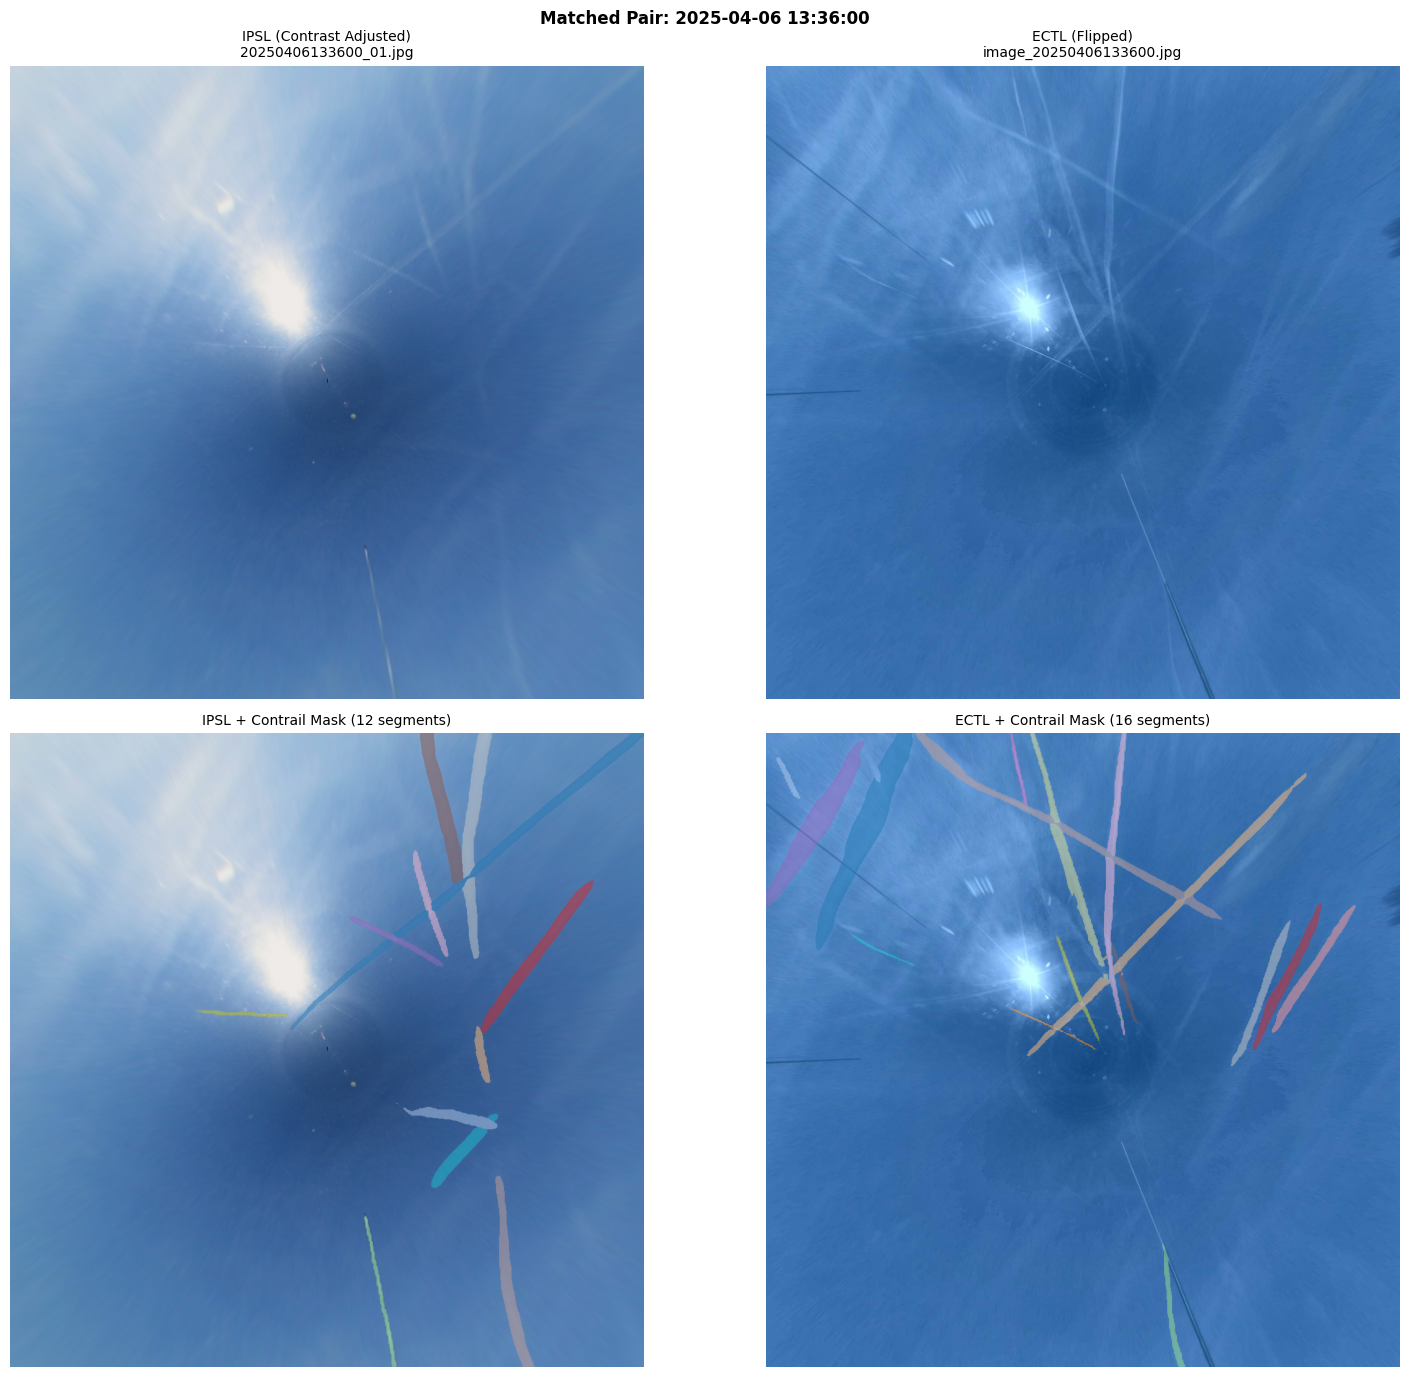


✓ Images ready for stereo matching
  Use img1, img2 for raw preprocessed images
  Use img1_overlay, img2_overlay for images with contrail masks


In [54]:
# Load and preprocess images
print("Loading and preprocessing images...")

# Load IPSL image and apply contrast adjustments
img1_raw = np.array(Image.open(pair['ipsl_path']).convert('RGB'))
img1 = match_right_look(img1_raw[..., ::-1])[..., ::-1]  # RGB->BGR, process, BGR->RGB
print(f"  IPSL loaded and contrast adjusted: {img1.shape}")

# Load ECTL image and flip vertically
img2 = np.array(Image.open(pair['ectl_path']).convert('RGB'))[::-1, :, :]
print(f"  ECTL loaded and flipped: {img2.shape}")

# Run Mask2Former inference
print("\nRunning Mask2Former inference...")
print("  Processing IPSL image...")
seg1 = run_inference(img1)
mask1 = extract_contrail_mask(seg1)
n_contrails_1 = sum(1 for s in seg1.get('segments_info', []) if id2label.get(s['label_id']) == 'contrail')
print(f"  IPSL: {n_contrails_1} contrail segments detected")

print("  Processing ECTL image...")
seg2 = run_inference(img2)
mask2 = extract_contrail_mask(seg2)
n_contrails_2 = sum(1 for s in seg2.get('segments_info', []) if id2label.get(s['label_id']) == 'contrail')
print(f"  ECTL: {n_contrails_2} contrail segments detected")

# Create overlay images (image + colored mask) - properly blended to avoid overflow
def create_overlay(img, mask_or_seg, color=(255, 0, 0), alpha=0.5, label_name='contrail', use_instance_colors=True):
    """
    Create an overlay of image with colored mask or segmentation.
    
    Args:
        img: RGB image as numpy array
        mask_or_seg: Either:
            - Binary mask (numpy array of bool)
            - Raw segmentation dict with 'segmentation' and 'segments_info' keys
        color: RGB color tuple for the overlay (default red, used for binary masks or if use_instance_colors=False)
        alpha: Transparency (0=transparent, 1=opaque)
        label_name: Which label to highlight (only used if mask_or_seg is segmentation dict)
        use_instance_colors: If True, use different colors per instance from segmentation (ignored for binary masks)
    
    Returns:
        Overlay image with colored mask blended on top
    """
    overlay = img.copy().astype(np.float32)
    
    # Case 1: Binary mask (backward compatible)
    if isinstance(mask_or_seg, np.ndarray):
        mask = mask_or_seg
        if mask is not None and mask.any():
            # Blend: overlay = (1-alpha)*img + alpha*color where mask is True
            overlay[mask] = (1 - alpha) * overlay[mask] + alpha * np.array(color, dtype=np.float32)
    
    # Case 2: Raw segmentation dict
    elif isinstance(mask_or_seg, dict) and 'segmentation' in mask_or_seg:
        seg_mask = mask_or_seg['segmentation'].cpu().numpy()
        
        # Generate distinct colors for instances if needed
        if use_instance_colors:
            # Use a colormap to generate distinct colors
            import matplotlib.cm as cm
            import matplotlib.colors as mcolors
            
            # Get matching segments
            matching_segments = [s for s in mask_or_seg.get('segments_info', []) 
                               if id2label.get(s['label_id'], '') == label_name]
            
            # Generate colors using a colormap
            n_instances = len(matching_segments)
            if n_instances > 0:
                cmap = cm.get_cmap('tab20' if n_instances <= 20 else 'hsv')
                
                for idx, seg_info in enumerate(matching_segments):
                    # Get color from colormap
                    instance_color = np.array(cmap(idx / max(n_instances, 1))[:3]) * 255
                    
                    # Create mask for this segment
                    instance_mask = (seg_mask == seg_info['id'])
                    
                    # Blend this instance with its unique color
                    overlay[instance_mask] = (1 - alpha) * overlay[instance_mask] + alpha * instance_color
        else:
            # Use single color for all instances
            for seg_info in mask_or_seg.get('segments_info', []):
                if id2label.get(seg_info['label_id'], '') == label_name:
                    instance_mask = (seg_mask == seg_info['id'])
                    overlay[instance_mask] = (1 - alpha) * overlay[instance_mask] + alpha * np.array(color, dtype=np.float32)
    
    return np.clip(overlay, 0, 255).astype(np.uint8)

# Save overlay images for later use (e.g., stereo matching visualization)
# Using raw segmentation output with instance colors
img1_overlay = create_overlay(img1, seg1, alpha=0.5, use_instance_colors=True)
img2_overlay = create_overlay(img2, seg2, alpha=0.5, use_instance_colors=True)
print(f"\n✓ Created overlay images: img1_overlay {img1_overlay.shape}, img2_overlay {img2_overlay.shape}")

# Visualize the preprocessed images with segmentation overlays
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Row 1: Preprocessed images (no overlay)
axes[0, 0].imshow(img1)
axes[0, 0].set_title(f'IPSL (Contrast Adjusted)\n{pair["ipsl_path"].name}', fontsize=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(img2)
axes[0, 1].set_title(f'ECTL (Flipped)\n{pair["ectl_path"].name}', fontsize=10)
axes[0, 1].axis('off')

# Row 2: Overlay images (with contrail mask)
axes[1, 0].imshow(img1_overlay)
axes[1, 0].set_title(f'IPSL + Contrail Mask ({n_contrails_1} segments)', fontsize=10)
axes[1, 0].axis('off')

axes[1, 1].imshow(img2_overlay)
axes[1, 1].set_title(f'ECTL + Contrail Mask ({n_contrails_2} segments)', fontsize=10)
axes[1, 1].axis('off')

plt.suptitle(f'Matched Pair: {pair["timestamp"]}', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Images ready for stereo matching")
print("  Use img1, img2 for raw preprocessed images")
print("  Use img1_overlay, img2_overlay for images with contrail masks")

## 5. Stereo Matching with LoFTR

In [55]:
# Initialize LoFTR matcher
loftr_matcher = LoFTRMatcher(device='cuda', pretrained='outdoor')
print(f"Matcher: {loftr_matcher}")

# Run matching on the preprocessed images
loftr_result = loftr_matcher.match(img1, img2)

print(f"\n{'='*60}")
print(f"MATCHING RESULTS: {loftr_result.model_name}")
print(f"{'='*60}")
print(f"Number of matches: {loftr_result.num_matches}")
print(f"Inference time: {loftr_result.inference_time:.3f}s")
if loftr_result.num_matches > 0:
    print(f"Keypoints shape: {loftr_result.keypoints0.shape}")
    print(f"\nConfidence statistics:")
    for key, val in loftr_result.confidence_stats.items():
        print(f"  {key}: {val:.4f}")

Matcher: LoFTRMatcher(device=cuda, loaded=False)



MATCHING RESULTS: LoFTR-outdoor
Number of matches: 262
Inference time: 0.126s
Keypoints shape: (262, 2)

Confidence statistics:
  mean: 0.3249
  median: 0.2808
  std: 0.1230
  min: 0.2000
  max: 0.8141


/data/common/STEREOSTUDYIPSL/DeepMatching/stereo_matchers/viz.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


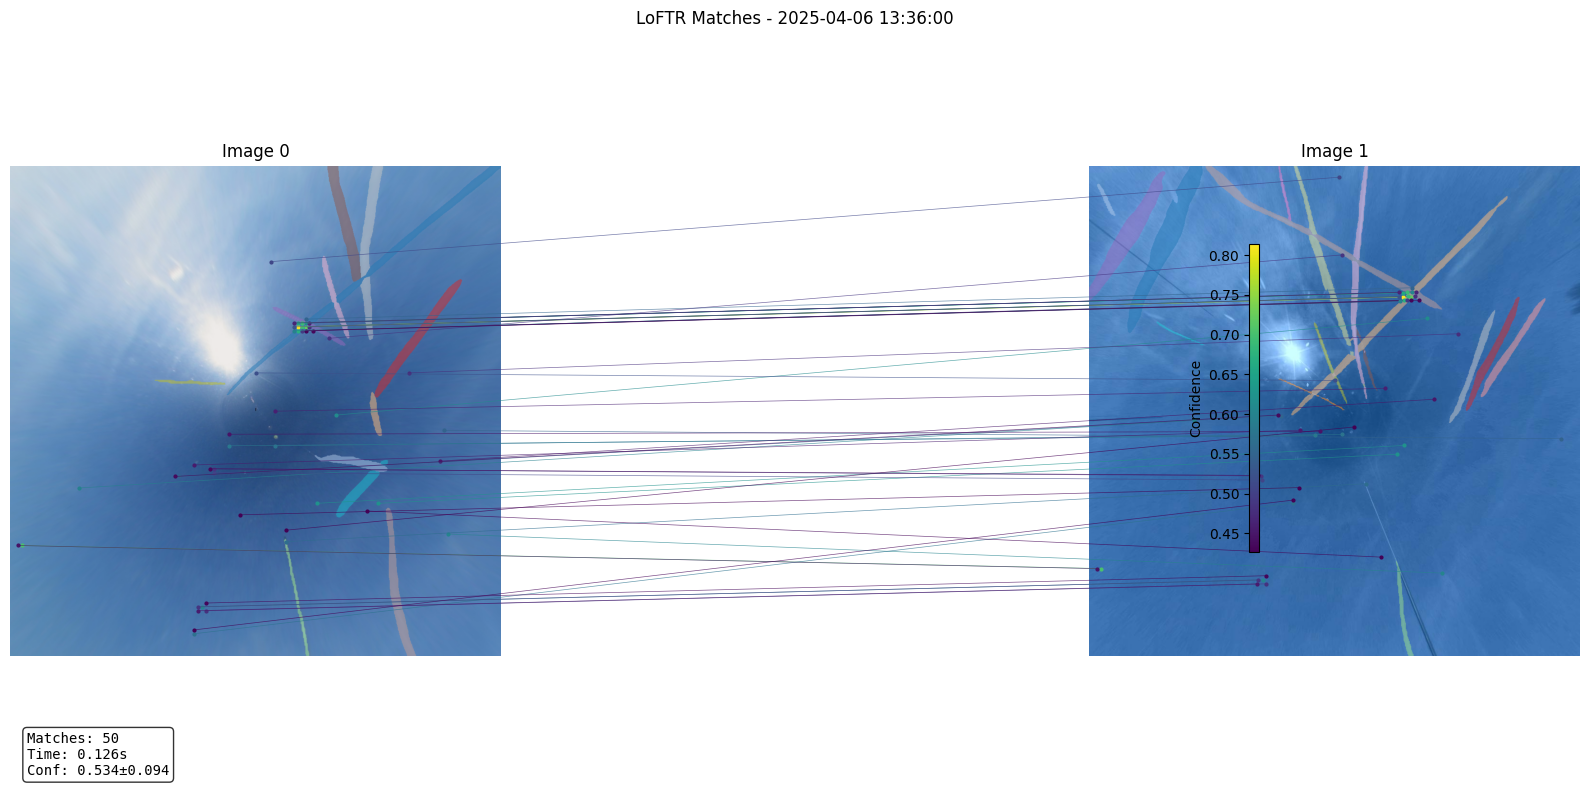

In [56]:
# Visualize LoFTR matches
fig = visualize_matches(
    img1_overlay, img2_overlay, loftr_result,
    top_k=50,
    figsize=(16, 8),
    color_by_confidence=True
)
plt.suptitle(f'LoFTR Matches - {pair["timestamp"]}', fontsize=12)
plt.show()

## 6. Stereo Matching with RoMa

In [57]:
# Reload the module to pick up the fix (tensor -> PIL Image conversion)
import importlib
import stereo_matchers.roma as roma_module
importlib.reload(roma_module)

# Re-import after reload
from stereo_matchers.roma import RoMaMatcher

# Initialize RoMa matcher (now with use_custom_corr=False for pure PyTorch local correlation)
roma_matcher = RoMaMatcher(device=device, model_type='outdoor')
print(f"✓ {roma_matcher.name} loaded on {device}")

# Run matching on the preprocessed images
roma_result = roma_matcher.match(img1_overlay, img2_overlay)

print(f"\n{'='*60}")
print(f"MATCHING RESULTS: {roma_result.model_name}")
print(f"{'='*60}")
print(f"Number of matches: {roma_result.num_matches}")
print(f"Inference time: {roma_result.inference_time:.3f}s")
if roma_result.num_matches > 0:
    print(f"Keypoints shape: {roma_result.keypoints0.shape}")
    print(f"\nConfidence statistics:")
    for key, val in roma_result.confidence_stats.items():
        print(f"  {key}: {val:.4f}")

✓ RoMa-outdoor loaded on cuda


2026-01-21 11:32:16.409 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 864)



MATCHING RESULTS: RoMa-outdoor
Number of matches: 10000
Inference time: 0.496s
Keypoints shape: (10000, 2)

Confidence statistics:
  mean: 0.7648
  median: 1.0000
  std: 0.4186
  min: 0.0001
  max: 1.0000


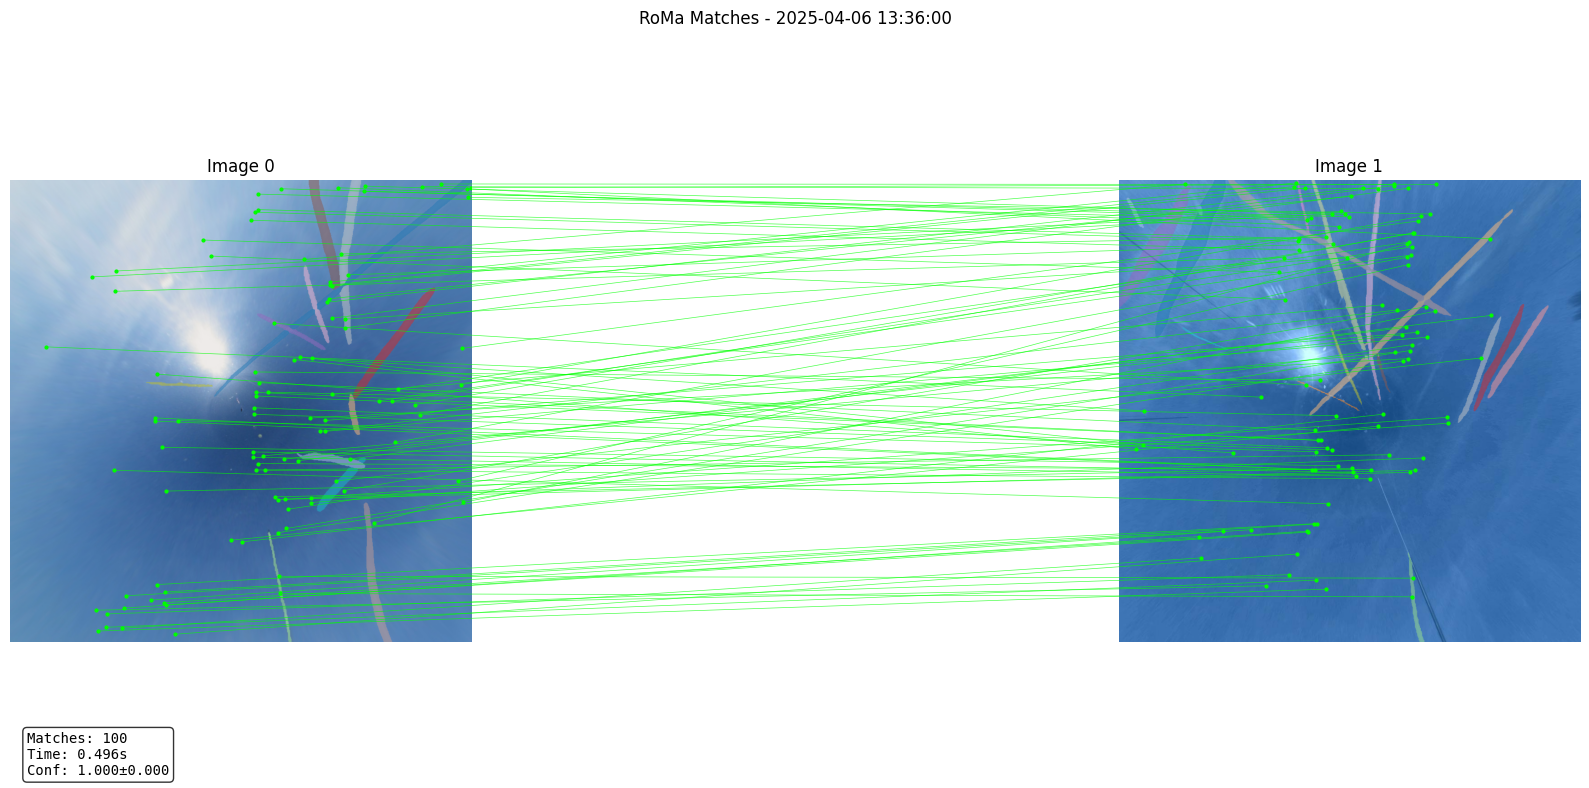

In [58]:
# Visualize RoMa matches
fig = visualize_matches(
    img1_overlay, img2_overlay, roma_result,
    top_k=100,
    figsize=(16, 8),
    color_by_confidence=False
)
plt.suptitle(f'RoMa Matches - {pair["timestamp"]}', fontsize=12)
plt.show()


RoMa matches with at least one keypoint on contrail: 1455
Original matches: 10000
Filtered out: 8545 (85.5%)


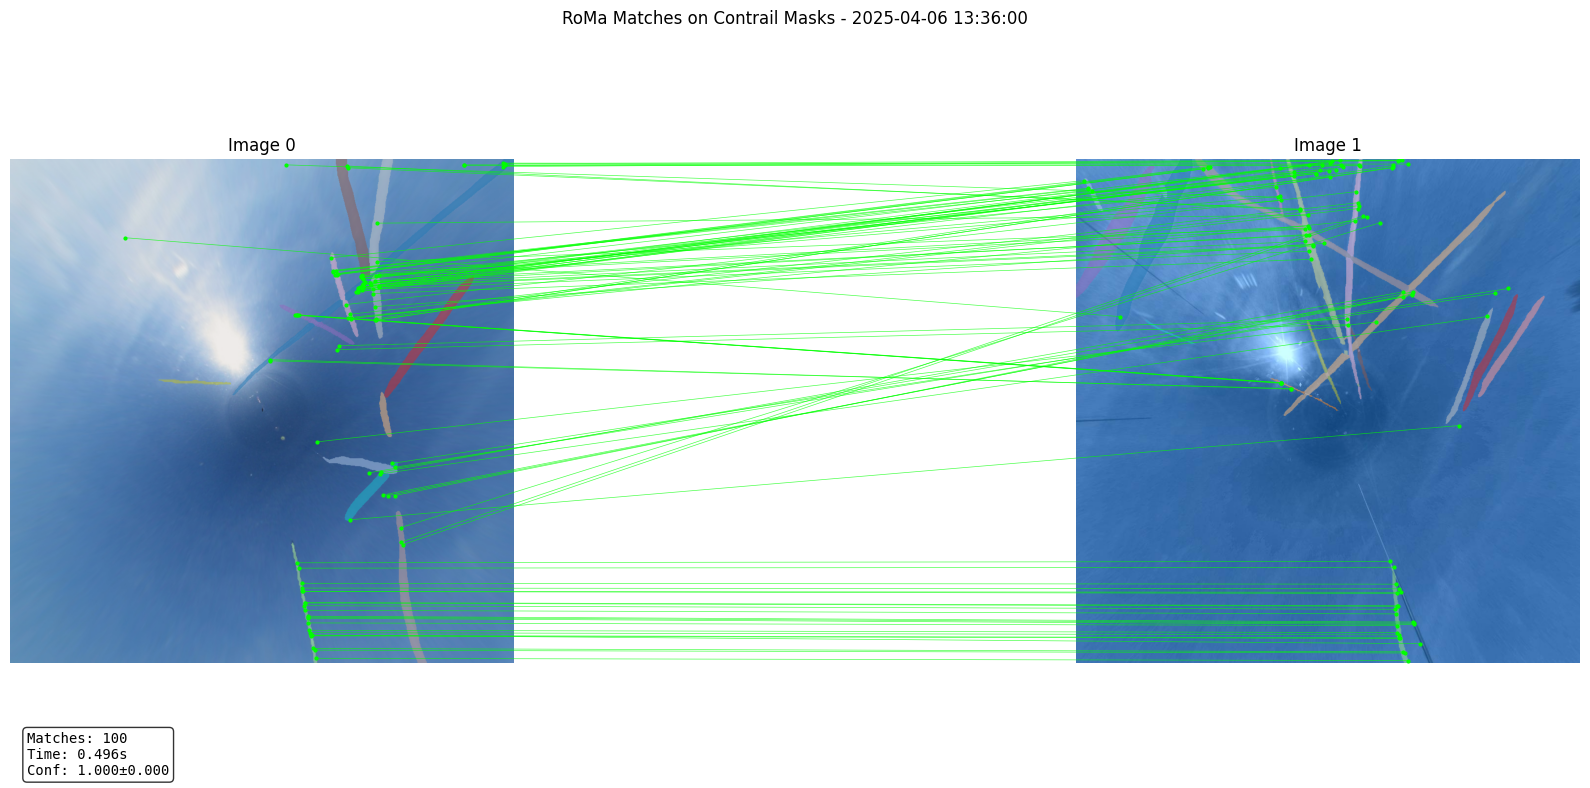

In [83]:
## 5* Filter matches if they are on masked contrail areas
def filter_matches_by_mask(match_result, seg1, seg2, label_name='contrail'):
    """
    Filter matches to keep only those where at least one keypoint is on a contrail.
    
    Args:
        match_result: MatchResult object with keypoints
        seg1: Segmentation dict for image 1 (with 'segmentation' and 'segments_info')
        seg2: Segmentation dict for image 2 (with 'segmentation' and 'segments_info')
        label_name: Label to filter by (default 'contrail')
    
    Returns:
        Filtered MatchResult with only matches where at least one keypoint is on a contrail
    """
    keypoints0 = match_result.keypoints0
    keypoints1 = match_result.keypoints1
    
    # Extract binary contrail masks from segmentation results
    mask1 = extract_contrail_mask(seg1, label_name)
    mask2 = extract_contrail_mask(seg2, label_name)
    
    # Check if keypoints are on contrail masks
    # Note: coordinates are (x, y) but array indexing is [y, x]
    mask1_hits = mask1[keypoints0[:, 1].astype(int), keypoints0[:, 0].astype(int)]
    mask2_hits = mask2[keypoints1[:, 1].astype(int), keypoints1[:, 0].astype(int)]
    
    # Keep matches where AT LEAST ONE keypoint is on a contrail (OR instead of AND)
    valid_mask = mask1_hits | mask2_hits
    
    # Create a new MatchResult with filtered matches (following filter_by_confidence pattern)
    from stereo_matchers import MatchResult
    filtered_result = MatchResult(
        keypoints0=match_result.keypoints0[valid_mask],
        keypoints1=match_result.keypoints1[valid_mask],
        confidence=match_result.confidence[valid_mask],
        num_matches=int(valid_mask.sum()),
        inference_time=match_result.inference_time,
        model_name=match_result.model_name,
        extra=match_result.extra
    )
    
    return filtered_result

# Visualize only matches on contrail masks
roma_filtered_masked = filter_matches_by_mask(roma_result, seg1, seg2)
print(f"\nRoMa matches with at least one keypoint on contrail: {roma_filtered_masked.num_matches}")
print(f"Original matches: {roma_result.num_matches}")
print(f"Filtered out: {roma_result.num_matches - roma_filtered_masked.num_matches} ({(1 - roma_filtered_masked.num_matches/roma_result.num_matches)*100:.1f}%)")

fig = visualize_matches(
    img1_overlay, img2_overlay, roma_filtered_masked,
    top_k=100,
    figsize=(16, 8),
    color_by_confidence=False
)
plt.suptitle(f'RoMa Matches on Contrail Masks - {pair["timestamp"]}', fontsize=12)
plt.show()

In [59]:
## 6. Filter Matches by Confidence
confidence_threshold = 0.5
filtered_result = roma_result.filter_by_confidence(confidence_threshold)
print(f"\nAfter filtering by confidence > {confidence_threshold}:")
print(f"Number of matches: {filtered_result.num_matches}")





After filtering by confidence > 0.5:
Number of matches: 7600


## 7. Compare Multiple Models

In [60]:
# Create benchmark with multiple models
benchmark = ModelBenchmark(
    models=['loftr', 'roma'],  # Start with just LoFTR; add 'roma', 'dkm' if installed
    device='cuda'
)

# Run on single pair
results = benchmark.run_single(img1, img2)

for model_name, res in results.items():
    print(f"\n{model_name}:")
    print(f"  Matches: {res.num_matches}")
    print(f"  Time: {res.inference_time:.3f}s")
    print(f"  Confidence mean: {res.confidence.mean():.3f}" if res.num_matches > 0 else "  No matches")

2026-01-21 11:32:23.343 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 864)



loftr:
  Matches: 262
  Time: 0.127s
  Confidence mean: 0.325

roma:
  Matches: 10000
  Time: 0.482s
  Confidence mean: 0.733


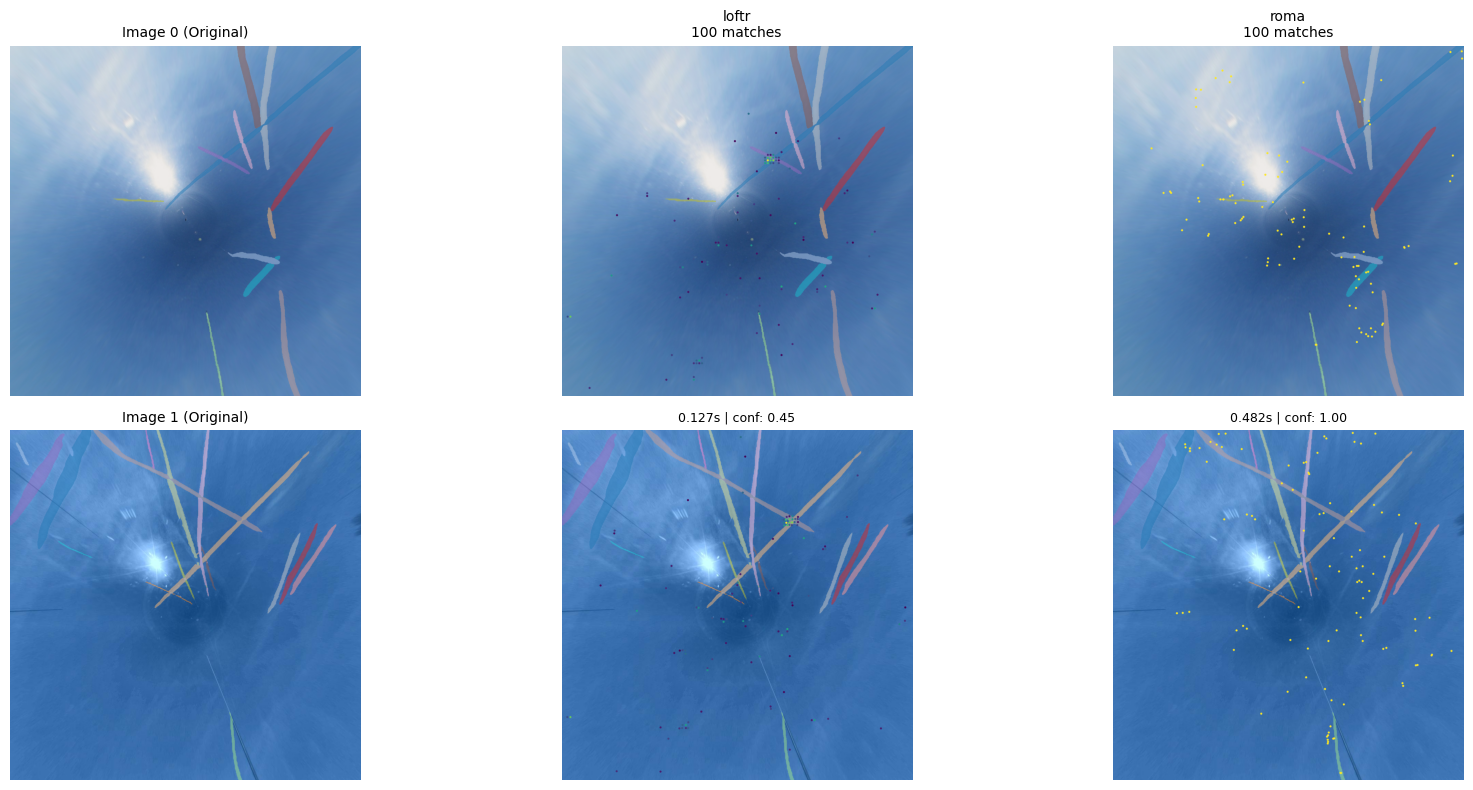

In [61]:
# Compare models visually
fig = compare_models(img1_overlay, img2_overlay, results, top_k=100, figsize=(18, 8))
plt.show()

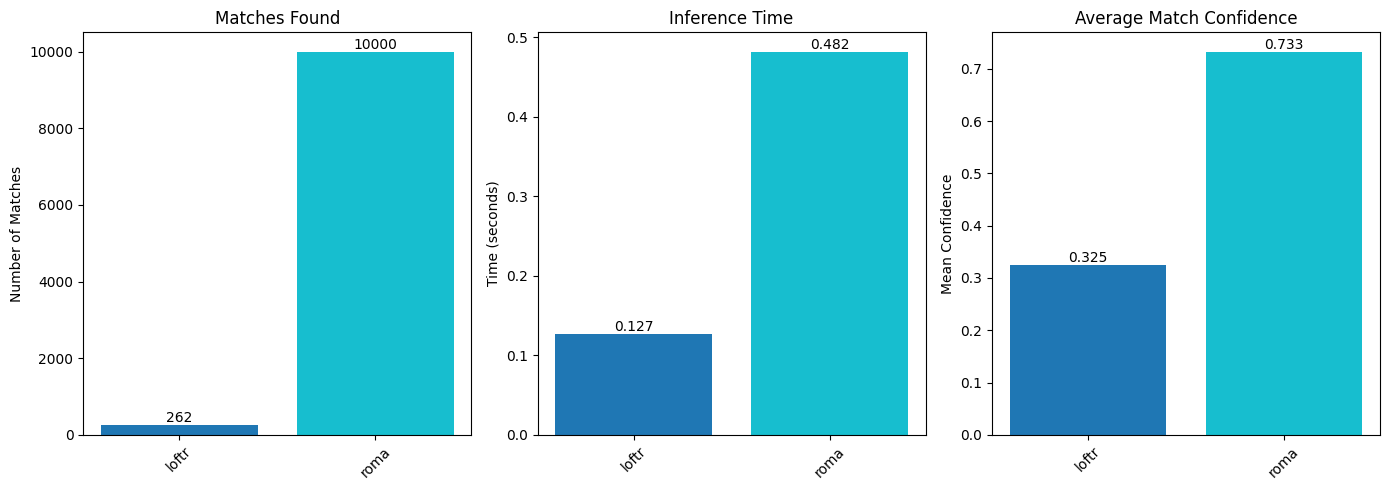

In [62]:
# Bar chart comparison
fig = plot_match_comparison(results, figsize=(14, 5))
plt.show()

## 8. Benchmark on Multiple Pairs

In [63]:
# Load multiple image pairs with preprocessing
num_pairs = min(3, len(filtered_pairs))
image_pairs = []

print(f"Loading {num_pairs} image pairs with preprocessing...")

for i, p in enumerate(filtered_pairs[:num_pairs]):
    # Load and preprocess IPSL
    i1_raw = np.array(Image.open(p['ipsl_path']).convert('RGB'))
    i1 = match_right_look(i1_raw[..., ::-1])[..., ::-1]
    
    # Load and flip ECTL
    i2 = np.array(Image.open(p['ectl_path']).convert('RGB'))[::-1, :, :]
    
    image_pairs.append((i1, i2))
    print(f"  Pair {i+1}: {p['timestamp']}")

print(f"\n✓ Loaded {len(image_pairs)} preprocessed image pairs for benchmarking")

Loading 3 image pairs with preprocessing...
  Pair 1: 2025-04-06 13:00:00
  Pair 2: 2025-04-06 13:02:00
  Pair 3: 2025-04-06 13:04:00

✓ Loaded 3 preprocessed image pairs for benchmarking


In [64]:
# Run benchmark on all pairs
benchmark = ModelBenchmark(models=['loftr'], device='cuda')
benchmark_results = benchmark.run(image_pairs, verbose=True)


Running loftr on 3 image pairs...
  Pair 1/3: 237 matches in 0.127s
  Pair 2/3: 285 matches in 0.127s
  Pair 3/3: 272 matches in 0.127s

loftr Summary:
  Total time: 0.55s
  Avg inference: 0.127s
  Avg matches: 264.7


In [65]:
# Get comparison table
df = benchmark.compare()
print("\nBenchmark Results:")
print(df.to_string(index=False))


Benchmark Results:
Model  Avg_Time_s  Avg_Matches  Total_Time_s  Conf_Mean  Conf_Median  Conf_Std  Conf_Min  Conf_Max  Num_Pairs
loftr    0.126956   264.666667       0.54663   0.321387     0.284513  0.122377  0.200028  0.839741          3


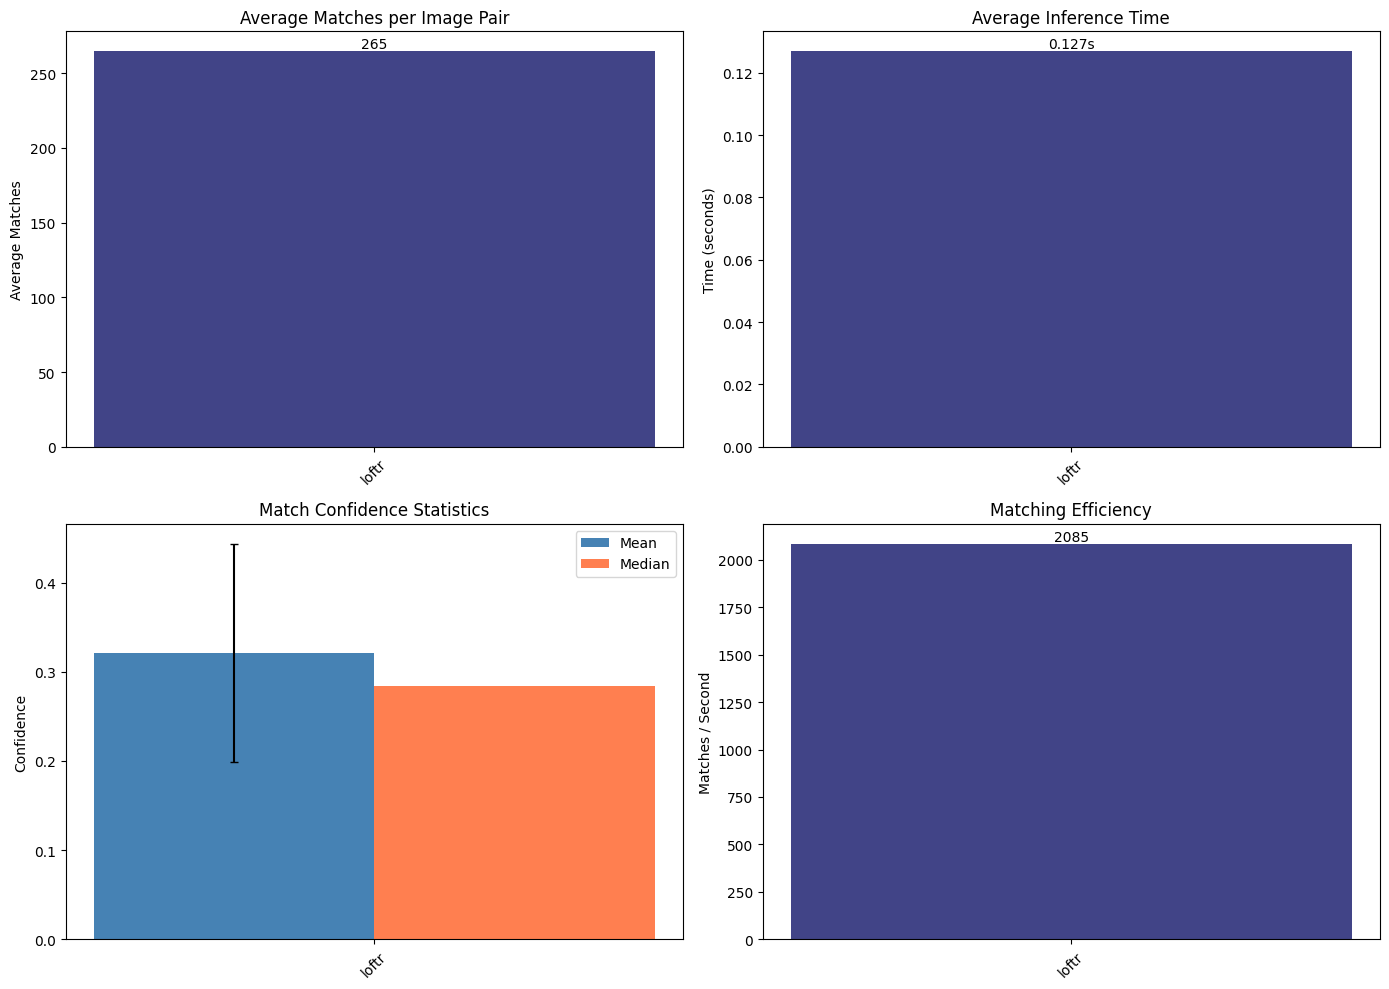

In [66]:
# Plot benchmark comparison
fig = benchmark.plot_comparison(figsize=(14, 10))
plt.show()

In [67]:
# Generate text report
report = benchmark.generate_report()
print(report)

STEREO MATCHER BENCHMARK REPORT

Models tested: loftr
Device: cuda

--------------------------------------------------------------------------------
SUMMARY TABLE
--------------------------------------------------------------------------------

Model  Avg_Time_s  Avg_Matches  Total_Time_s  Conf_Mean  Conf_Median  Conf_Std  Conf_Min  Conf_Max  Num_Pairs
loftr    0.126956   264.666667       0.54663   0.321387     0.284513  0.122377  0.200028  0.839741          3

--------------------------------------------------------------------------------
KEY FINDINGS
--------------------------------------------------------------------------------

✓ Most matches: loftr (265 avg)
✓ Fastest: loftr (0.127s avg)
✓ Best confidence: loftr (0.321 mean)



## 9. Integration with Existing Pipeline

In [84]:
# Example: Use matching results for downstream processing

def process_match_result(result):
    """
    Example of using match results for further processing.
    """
    # Get high-confidence matches
    good_matches = result.filter_by_confidence(0.5)
    
    if good_matches.num_matches < 4:
        return None, "Not enough matches"
    
    # Estimate fundamental matrix
    import cv2
    F, mask = cv2.findFundamentalMat(
        good_matches.keypoints0,
        good_matches.keypoints1,
        cv2.FM_RANSAC,
        ransacReprojThreshold=3.0
    )
    
    n_inliers = mask.sum() if mask is not None else 0
    
    return F, f"Inliers: {n_inliers}/{good_matches.num_matches}"

# Run on our result
F, msg = process_match_result(roma_filtered_masked)
print(f"Fundamental matrix estimation: {msg}")
if F is not None:
    print(f"F matrix shape: {F.shape}")

Fundamental matrix estimation: Inliers: 242/1162
F matrix shape: (3, 3)


## Summary

This notebook demonstrated:

1. **Image Loading**: Loading matched IPSL/ECTL pairs by timestamp
2. **Preprocessing**: Applying contrast adjustments to IPSL, vertical flip to ECTL
3. **Mask2Former Inference**: Running contrail segmentation on both images
4. **Stereo Matching**: Using LoFTR to find correspondences between views
5. **Filtering**: Filtering matches by confidence threshold
6. **Benchmarking**: Comparing model performance on multiple pairs
7. **Integration**: Using match results for geometric estimation (fundamental matrix)

### Key Preprocessing Steps

- **IPSL**: Contrast adjustments (exposure=-0.10, contrast=0.35, hl=-0.55, clarity=0.1)
- **ECTL**: Vertical flip (image is mounted upside-down)
- **Time window**: 1-3 PM for best contrail visibility

### Next Steps

- Use matched keypoints for stereo triangulation of contrails
- Filter matches to contrail regions using segmentation masks
- Estimate contrail altitude from stereo geometry

## 10. 3D Altitude Estimation from Stereo Matching

Now we extend the stereo matching to **3D altitude estimation**. Using the pixel correspondences from LoFTR/RoMa and the known camera positions, we triangulate the 3D positions of matched features.

**Key concepts:**
- **Fisheye projection**: The 180° hemispherical FOV means pixels map to viewing angles (azimuth, elevation)
- **Long baseline**: The ~15 km separation between cameras provides good triangulation geometry
- **Ray intersection**: For each matched pair, we find where viewing rays from both cameras intersect

In [85]:
# Add the stereo_3d module to path and import
import sys
import importlib

# Add path for stereo_3d module
sys.path.insert(0, '/data/common/STEREOSTUDYIPSL/DeepMatching')

# Reload module if already imported (for development)
if 'stereo_3d' in sys.modules:
    del sys.modules['stereo_3d']
    # Also remove submodules
    for key in list(sys.modules.keys()):
        if key.startswith('stereo_3d.'):
            del sys.modules[key]

from stereo_3d import (
    AtmosphericTriangulator,
    CameraParams,
    filter_altitude_estimates,
    FilterConfig,
    FILTER_MODERATE,
    visualize_matches_with_altitude,
    create_3d_pointcloud_view,
    plot_altitude_histogram,
    create_summary_figure,
    estimate_altitude_uncertainty,
)

print("✅ stereo_3d module imported successfully")

✅ stereo_3d module imported successfully


In [86]:
# Define camera parameters for SIRTA-IPSL and ECTL
# These are the Reuniwatt Sky Cam Vision 180° FOV cameras

cam1_params = CameraParams(
    lat=48.7132,      # SIRTA-IPSL latitude
    lon=2.207,        # SIRTA-IPSL longitude
    height=177.5,     # Elevation above sea level (m)
    image_width=img1.shape[1],
    image_height=img1.shape[0],
    fov_degrees=180.0,
    name="SIRTA-IPSL"
)

cam2_params = CameraParams(
    lat=48.600518,    # ECTL latitude
    lon=2.346795,     # ECTL longitude  
    height=90.0,      # Elevation above sea level (m)
    image_width=img2.shape[1],
    image_height=img2.shape[0],
    fov_degrees=180.0,
    name="ECTL"
)

# Create the triangulator
triangulator = AtmosphericTriangulator(cam1_params, cam2_params)

# Print baseline information
print(f"Camera 1 ({cam1_params.name}): {cam1_params.lat:.4f}°N, {cam1_params.lon:.4f}°E, {cam1_params.height}m")
print(f"Camera 2 ({cam2_params.name}): {cam2_params.lat:.4f}°N, {cam2_params.lon:.4f}°E, {cam2_params.height}m")
print(f"\n📏 Baseline distance: {triangulator.baseline_horizontal/1000:.2f} km (horizontal)")
print(f"📐 Baseline azimuth: {triangulator.baseline_azimuth:.1f}° (from cam1 to cam2)")

Camera 1 (SIRTA-IPSL): 48.7132°N, 2.2070°E, 177.5m
Camera 2 (ECTL): 48.6005°N, 2.3468°E, 90.0m

📏 Baseline distance: 16.22 km (horizontal)
📐 Baseline azimuth: 140.5° (from cam1 to cam2)


In [87]:
# Triangulate the LoFTR matches
print("🔺 Triangulating LoFTR matches...")
loftr_altitude_result = triangulator.triangulate_from_match_result(loftr_result)

print(f"\n📊 LoFTR 3D Estimation Results:")
print(f"   Total matches: {len(loftr_altitude_result.altitudes)}")
print(f"   Altitude range: {loftr_altitude_result.altitudes.min()/1000:.2f} - {loftr_altitude_result.altitudes.max()/1000:.2f} km")
print(f"   Mean altitude: {np.nanmean(loftr_altitude_result.altitudes)/1000:.2f} km")
print(f"   Median altitude: {np.nanmedian(loftr_altitude_result.altitudes)/1000:.2f} km")
print(f"   Mean triangulation angle: {np.degrees(np.nanmean(loftr_altitude_result.triangulation_angles)):.2f}°")
print(f"   Mean ray miss distance: {np.nanmean(loftr_altitude_result.ray_miss_distances):.1f} m")

🔺 Triangulating LoFTR matches...

📊 LoFTR 3D Estimation Results:
   Total matches: 262
   Altitude range: 0.13 - 290.69 km
   Mean altitude: 20.39 km
   Median altitude: 7.02 km
   Mean triangulation angle: 1025.02°
   Mean ray miss distance: 10332.5 m


In [88]:
# The default filter thresholds are too strict for our long-baseline (~16km) system
# Large miss distances are expected because rays may pass several km apart
# Create a custom filter configuration appropriate for this geometry

from stereo_3d import FilterConfig

# Custom filter for long-baseline atmospheric stereo
FILTER_LONGBASELINE = FilterConfig(
    min_tri_angle=5.0,       # Accept smaller angles (rays more parallel at distance)
    max_tri_angle=80.0,      # Still reject very large angles (matching errors)
    min_elevation=5.0,       # Accept lower elevations (near horizon features)
    min_altitude=100.0,      # Accept features as low as 100m
    max_altitude=20000.0,    # Clouds up to 20 km (troposphere + some stratosphere)
    max_miss_distance=5000.0,  # Accept miss distances up to 5 km (for 16 km baseline)
    max_uncertainty=10000.0,  # Accept higher uncertainty (large distances)
    min_confidence=0.1       # Accept lower confidence matches
)

# Re-run filtering with relaxed config
loftr_filtered, loftr_mask, loftr_metrics = filter_altitude_estimates(
    loftr_altitude_result, 
    config=FILTER_LONGBASELINE,
    return_metrics=True
)

print("🔍 Quality Filtering Results (Long-Baseline Config):")
print(f"   Original matches: {loftr_metrics.total_points}")
print(f"   After filtering: {loftr_metrics.filtered_points}")
print(f"   Pass rate: {loftr_metrics.pass_rate*100:.1f}%")
print(f"\n📈 Filter breakdown (rejected by each criterion):")
print(f"   By altitude range: {loftr_metrics.rejected_by_altitude}")
print(f"   By triangulation angle: {loftr_metrics.rejected_by_tri_angle}")
print(f"   By elevation: {loftr_metrics.rejected_by_elevation}")
print(f"   By miss distance: {loftr_metrics.rejected_by_miss_distance}")
print(f"   By uncertainty: {loftr_metrics.rejected_by_uncertainty}")

if loftr_metrics.filtered_points > 0:
    print(f"\n📊 Filtered altitude statistics:")
    print(f"   Mean: {loftr_metrics.altitude_mean/1000:.2f} km")
    print(f"   Median: {loftr_metrics.altitude_median/1000:.2f} km")
    print(f"   Range: {loftr_metrics.altitude_min/1000:.2f} - {loftr_metrics.altitude_max/1000:.2f} km")

🔍 Quality Filtering Results (Long-Baseline Config):
   Original matches: 262
   After filtering: 21
   Pass rate: 8.0%

📈 Filter breakdown (rejected by each criterion):
   By altitude range: 75
   By triangulation angle: 23
   By elevation: 35
   By miss distance: 197
   By uncertainty: 203

📊 Filtered altitude statistics:
   Mean: 13.09 km
   Median: 16.02 km
   Range: 1.98 - 19.82 km


In [ ]:
# Visualize matches with altitude coloring (using filtered results)
fig_altitude = visualize_matches_with_altitude(
    img1, img2, 
    roma_filtered_masked,  # Use filtered result
    title="RoMa Matches with Altitude Coloring (Filtered)",
    min_altitude=0,
    max_altitude=20000,  # 0-20 km range
    show_colorbar=False
)
plt.show()

AttributeError: 'MatchResult' object has no attribute 'num_points'

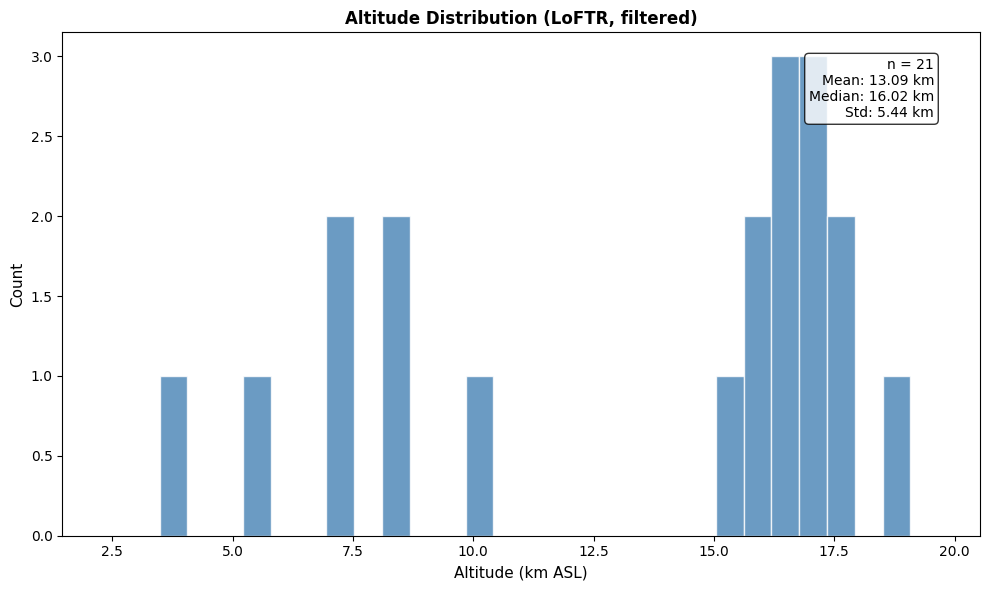

In [90]:
# Show altitude histogram
fig_hist = plot_altitude_histogram(
    loftr_filtered,
    bins=30,
    title="Altitude Distribution (LoFTR, filtered)",
    show_stats=True
)
plt.show()

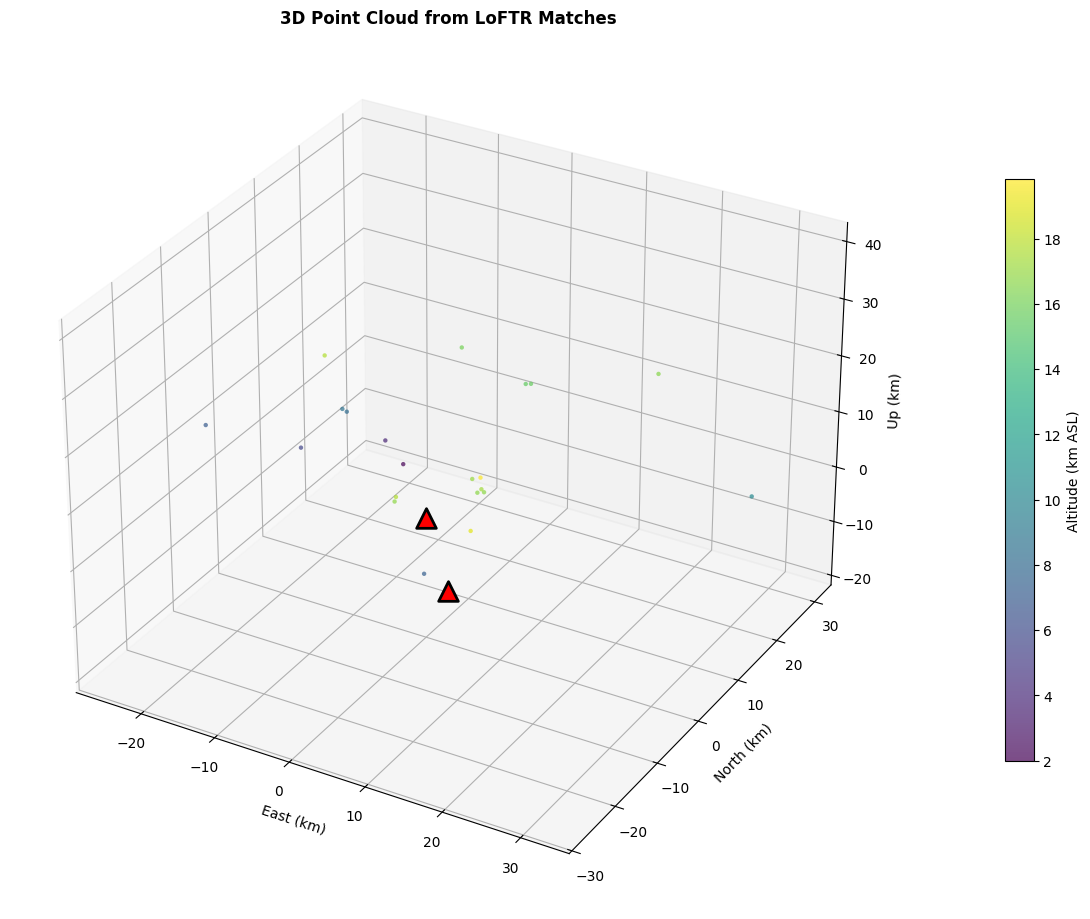

Camera 1 (origin): (0.0, 0.0, 0.0)
Camera 2 ENU: (10.31 km E, -12.52 km N, -0.11 km U)


In [91]:
# Create 3D point cloud visualization
# Get camera positions in ENU (using cam1 as reference)
from stereo_3d.coordinates import CoordinateTransforms

cam1_enu = (0.0, 0.0, 0.0)  # Reference point at origin
cam2_enu = CoordinateTransforms.ecef_to_enu(
    *CoordinateTransforms.geographic_to_ecef(cam2_params.lat, cam2_params.lon, cam2_params.height),
    cam1_params.lat, cam1_params.lon, cam1_params.height
)

fig_3d = create_3d_pointcloud_view(
    loftr_filtered,
    camera_positions=[cam1_enu, cam2_enu],
    title="3D Point Cloud from LoFTR Matches",
    show_cameras=True,
)
plt.show()

print(f"Camera 1 (origin): {cam1_enu}")
print(f"Camera 2 ENU: ({cam2_enu[0]/1000:.2f} km E, {cam2_enu[1]/1000:.2f} km N, {cam2_enu[2]/1000:.2f} km U)")

### 10.1 Processing RoMa Matches

RoMa provides many more matches (10,000+), which can give denser altitude coverage but may include more noise.

In [93]:
# Triangulate RoMa matches  
print("🔺 Triangulating RoMa matches...")
roma_altitude_result = triangulator.triangulate_from_match_result(roma_filtered_masked)

# Apply quality filtering with long-baseline config
roma_filtered, roma_mask, roma_metrics = filter_altitude_estimates(
    roma_altitude_result,
    config=FILTER_LONGBASELINE,
    return_metrics=True
)

print(f"\n📊 RoMa 3D Estimation Results:")
print(f"   Total matches: {roma_metrics.total_points}")
print(f"   After filtering: {roma_metrics.filtered_points} ({roma_metrics.pass_rate*100:.1f}%)")

if roma_metrics.filtered_points > 0:
    print(f"   Altitude range (filtered): {roma_metrics.altitude_min/1000:.2f} - {roma_metrics.altitude_max/1000:.2f} km")
    print(f"   Median altitude: {roma_metrics.altitude_median/1000:.2f} km")

🔺 Triangulating RoMa matches...

📊 RoMa 3D Estimation Results:
   Total matches: 1455
   After filtering: 189 (13.0%)
   Altitude range (filtered): 3.49 - 13.63 km
   Median altitude: 8.10 km


In [94]:
# Create comprehensive summary figure for RoMa
fig_summary = create_summary_figure(
    roma_filtered,
    img1, img2,
    title="RoMa 3D Altitude Estimation Summary"
)
plt.tight_layout()
plt.show()

TypeError: create_summary_figure() missing 1 required positional argument: 'filtered_result'

### 10.2 Comparison: LoFTR vs RoMa

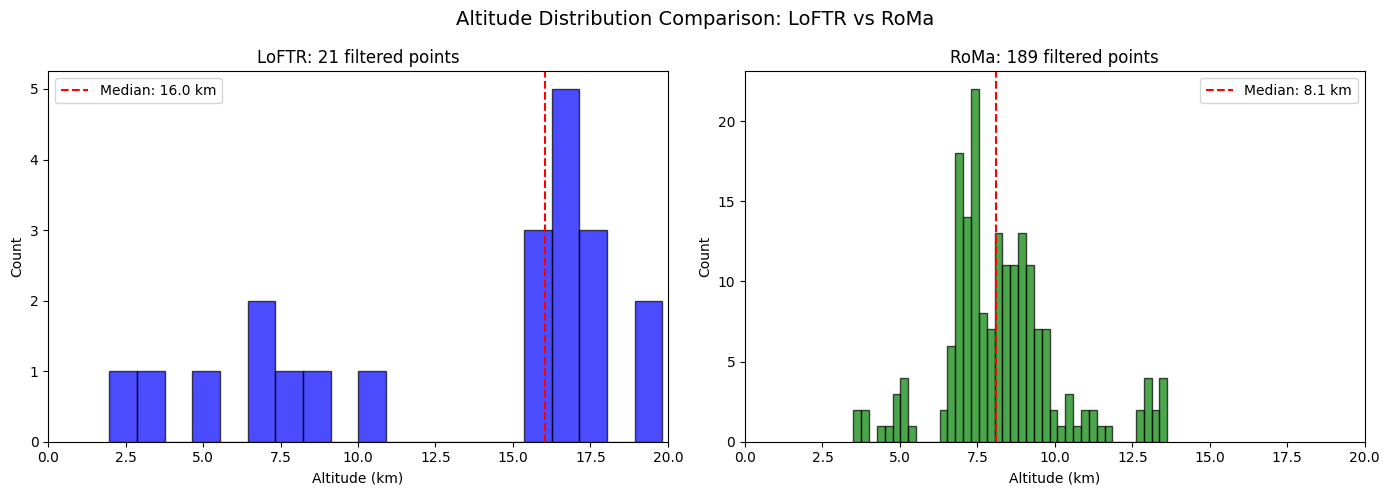


📊 ALTITUDE ESTIMATION COMPARISON
Metric                              LoFTR            RoMa
------------------------------------------------------------
Original matches                      262            1455
After filtering                        21             189
Pass rate                            8.0%           13.0%
Median altitude (km)                16.02            8.10
Mean altitude (km)                  13.09            8.28
Std deviation (km)                   5.44            1.94


In [95]:
# Compare altitude estimates from both matchers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LoFTR histogram
ax1 = axes[0]
if len(loftr_filtered.altitudes) > 0:
    ax1.hist(loftr_filtered.altitudes/1000, bins=20, color='blue', alpha=0.7, edgecolor='black')
    ax1.axvline(np.median(loftr_filtered.altitudes)/1000, color='red', linestyle='--', 
                label=f'Median: {np.median(loftr_filtered.altitudes)/1000:.1f} km')
    ax1.legend()
ax1.set_xlabel('Altitude (km)')
ax1.set_ylabel('Count')
ax1.set_title(f'LoFTR: {len(loftr_filtered.altitudes)} filtered points')
ax1.set_xlim(0, 20)

# RoMa histogram
ax2 = axes[1]
if len(roma_filtered.altitudes) > 0:
    ax2.hist(roma_filtered.altitudes/1000, bins=40, color='green', alpha=0.7, edgecolor='black')
    ax2.axvline(np.median(roma_filtered.altitudes)/1000, color='red', linestyle='--',
                label=f'Median: {np.median(roma_filtered.altitudes)/1000:.1f} km')
    ax2.legend()
ax2.set_xlabel('Altitude (km)')
ax2.set_ylabel('Count')
ax2.set_title(f'RoMa: {len(roma_filtered.altitudes)} filtered points')
ax2.set_xlim(0, 20)

plt.suptitle('Altitude Distribution Comparison: LoFTR vs RoMa', fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*60)
print("📊 ALTITUDE ESTIMATION COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'LoFTR':>15} {'RoMa':>15}")
print("-"*60)
print(f"{'Original matches':<25} {loftr_metrics.total_points:>15} {roma_metrics.total_points:>15}")
print(f"{'After filtering':<25} {loftr_metrics.filtered_points:>15} {roma_metrics.filtered_points:>15}")
print(f"{'Pass rate':<25} {loftr_metrics.pass_rate*100:>14.1f}% {roma_metrics.pass_rate*100:>14.1f}%")

if loftr_metrics.filtered_points > 0 and roma_metrics.filtered_points > 0:
    print(f"{'Median altitude (km)':<25} {loftr_metrics.altitude_median/1000:>15.2f} {roma_metrics.altitude_median/1000:>15.2f}")
    print(f"{'Mean altitude (km)':<25} {loftr_metrics.altitude_mean/1000:>15.2f} {roma_metrics.altitude_mean/1000:>15.2f}")
    print(f"{'Std deviation (km)':<25} {loftr_metrics.altitude_std/1000:>15.2f} {roma_metrics.altitude_std/1000:>15.2f}")
print("="*60)

### 10.3 Save Results to CSV

Save the altitude estimates for further analysis.

In [ ]:
# Save filtered results to CSV
output_dir = Path("../outputs/altitude_estimates")
output_dir.mkdir(parents=True, exist_ok=True)

# Save LoFTR results
loftr_output_path = output_dir / "loftr_altitude_results.csv"
loftr_filtered.save_csv(loftr_output_path)
print(f"✅ Saved LoFTR results: {loftr_output_path}")

# Save RoMa results  
roma_output_path = output_dir / "roma_altitude_results.csv"
roma_filtered.save_csv(roma_output_path)
print(f"✅ Saved RoMa results: {roma_output_path}")

# Print summary
print(f"\n📋 Results Summary:")
print(loftr_filtered.summary())

✅ Saved LoFTR results: ../outputs/altitude_estimates/loftr_altitude_results.csv
✅ Saved RoMa results: ../outputs/altitude_estimates/roma_altitude_results.csv

📋 Results Summary:
ALTITUDE ESTIMATION RESULTS
Total points: 21

Altitude Statistics:
  Range: 1979 - 19817 m ASL
  Mean:  13094 ± 5441 m
  Median: 16022 m

Quality Metrics:
  Triangulation angle: 27.6° (mean), 27.4° (median)
  Ray miss distance: 2884.7 m (mean), 3297.8 m (median)
  Uncertainty: 5793 m (mean), 6602 m (median)
